In [143]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import re
import datetime
import pickle
import nltk
import sklearn
import matplotlib.pyplot as plt
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [200]:
# load in tweets
with open('../data/pickled_tweets/home_2019_3daysback_nolikecriterion.pkl', 'rb') as f:
    home_2019_tweets = pickle.load(f)
with open('../data/pickled_tweets/away_2019_3daysback_nolikecriterion.pkl', 'rb') as f:
    away_2019_tweets = pickle.load(f)
with open('../data/pickled_tweets/home_2020_3daysback_nolikecriterion.pkl', 'rb') as f:
    home_2020_tweets = pickle.load(f)
with open('../data/pickled_tweets/away_2020_3daysback_nolikecriterion.pkl', 'rb') as f:
    away_2020_tweets = pickle.load(f)

# load in nfl data
s2020 = pd.read_csv('../data/season_data/2020_all_data.csv', index_col=0)
s2019 = pd.read_csv('../data/season_data/2019_all_data.csv', index_col=0)

In [201]:
sw = stopwords.words('english')

# lemmatize function
def lemmatize(sentence, include_stopwords=False):
    if include_stopwords:
        return [WordNetLemmatizer().lemmatize(word) for word in sentence]
    return [WordNetLemmatizer().lemmatize(word) for word in sentence if word not in sw]

# preprocess the tweets - remove punctuation and lemmatize
def preprocess(tweets):
    for i in range(len(tweets)):
        for j in range(len(tweets[i])):
            tweets[i][j] = re.sub('[^a-zA-Z]',' ',tweets[i][j]).split()
            tweets[i][j] = lemmatize(tweets[i][j])

preprocess(home_2019_tweets)
preprocess(away_2019_tweets)
preprocess(home_2020_tweets)
preprocess(away_2020_tweets)

In [202]:
from collections import Counter
def vectorize_list(list_of_tweets, corpus):
    num_tweets = len(list_of_tweets)
    lol = [nltk.bigrams(x) for x in list_of_tweets]
    with_repeats = [item for sublist in lol for item in sublist]
    counts = dict(Counter(with_repeats))
    to_return = []
    for key in corpus:
        num = np.log(1+counts[key]) if key in counts else 0
        to_return.append(num)
    return to_return

In [160]:
# count bigrams
def count_bigrams(tweet,corpus):
    bigramized_tweet = nltk.bigrams(tweet)
    for bigram in bigramized_tweet:
        if bigram in corpus:
            corpus[bigram] += 1
        else:
            corpus[bigram] = 1

In [203]:
#Create the home/away corpus
home_corpus = {}
away_corpus = {}
for tweets in home_2019_tweets:
    for tw in tweets:
        count_bigrams(tw,home_corpus)

for tweets in away_2019_tweets:
    for tw in tweets:
        count_bigrams(tw,away_corpus)

In [204]:
# get number of tweets for all home and away teams
n_home_tweets = sum([len(game_tweets) for game_tweets in home_2019_tweets])
n_away_tweets = sum([len(game_tweets) for game_tweets in away_2019_tweets])

# get the unigrams that appear in at least 0.1% of home/away tweets
home_top_grams = [word for word in home_corpus if home_corpus[word] > n_home_tweets*0.0001]
away_top_grams = [word for word in away_corpus if away_corpus[word] > n_away_tweets*0.0001]

In [205]:
# TRAIN SET
#Create lists of vectors for home, away games
num_h_tweets = [vectorize_list(game, home_top_grams) for game in home_2019_tweets]
num_a_tweets = [vectorize_list(game, away_top_grams) for game in away_2019_tweets]

#Turn into arrays
home_vecs = np.array(num_h_tweets)
away_vecs = np.array(num_a_tweets)

#Concatenate home, away to form input matrix.
X_train = np.concatenate([home_vecs, away_vecs], axis=1)

# TEST SET
#Create lists of vectors for home, away games
num_h_tweets = [vectorize_list(game, home_top_grams) for game in home_2020_tweets]
num_a_tweets = [vectorize_list(game, away_top_grams) for game in away_2020_tweets]

#Turn into arrays
home_vecs = np.array(num_h_tweets)
away_vecs = np.array(num_a_tweets)

#Concatenate home, away to form input matrix.
X_test = np.concatenate([home_vecs, away_vecs], axis=1)

# TRAIN and TEST outcomes
Y_train = np.array(s2019["Home Win"])
Y_test = np.array(s2020["Home Win"])

In [206]:
# Basic classifiers on full data
lr = LogisticRegression(penalty="l1",solver="liblinear",C=0.1)
lr.fit(X_train, Y_train)
print(lr.score(X_test, Y_test))

ada = AdaBoostClassifier(n_estimators=200)
ada.fit(X_train, Y_train)
print(ada.score(X_test, Y_test))

rf = RandomForestClassifier(n_estimators=400)
rf.fit(X_train, Y_train)
print(rf.score(X_test, Y_test))

mlp = MLPClassifier(max_iter=10000)
mlp.fit(X_train, Y_train)
print(mlp.score(X_test, Y_test))

gnb = GaussianNB().fit(X_train, Y_train)
gnb.fit(X_train, Y_train)
print(gnb.score(X_test, Y_test))

0.578125
0.5625
0.609375
0.625
0.53125


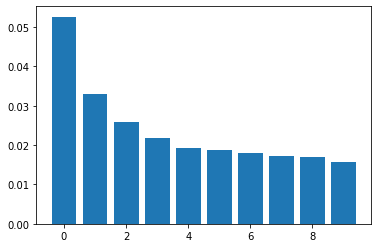

In [213]:
# Use PCA to reduce dimensions of X to n components
n = 10
pca = sklearn.decomposition.PCA(n_components=n)
pca.fit(X_train)
plt.bar(x=range(n),height=pca.explained_variance_ratio_)
reduced_X_train = pca.transform(X_train)
reduced_X_test = pca.transform(X_test)

In [214]:
# Basic classifiers on reduced data
lr = LogisticRegression()
lr.fit(reduced_X_train, Y_train)
print(lr.score(reduced_X_test, Y_test))

ada = AdaBoostClassifier(n_estimators=200)
ada.fit(reduced_X_train, Y_train)
print(ada.score(reduced_X_test, Y_test))

rf = RandomForestClassifier(n_estimators=400)
rf.fit(reduced_X_train, Y_train)
print(rf.score(reduced_X_test, Y_test))

mlp = MLPClassifier(max_iter=10000)
mlp.fit(reduced_X_train, Y_train)
print(mlp.score(reduced_X_test, Y_test))

gnb = GaussianNB().fit(reduced_X_train, Y_train)
gnb.fit(reduced_X_train, Y_train)
print(gnb.score(reduced_X_test, Y_test))

0.5703125
0.51171875
0.58203125
0.59765625
0.51171875
